In [1]:
import tkinter as tk
from tkinter import filedialog
import cv2
import mediapipe as mp
import numpy as np
import PIL.Image, PIL.ImageTk
from tkinter import ttk
# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to process video and compute gait parameters


# Function to handle file upload

# Tkinter app

# upload_button = tk.Button(root, text="Upload Video", font=font_style, bg="#007bff", fg="white", padx=10, pady=5, command=upload_file)
# video_label = tk.Label(root, bg="black")
# result_label = tk.Label(root, font=font_style, bg="#f0f0f0")

# # Pack widgets
# upload_button.pack(pady=10)
# video_label.pack()
# result_label.pack(pady=10)

# # Start the Tkinter event loop
# root.mainloop()

In [2]:
#to run


def process_video(file_path):
    cap = cv2.VideoCapture(file_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    gait_parameters = {
        'right_ankle': [],
        'right_knee': [],
        'right_hip': [],
        'left_hip': [],
        'left_knee': [],
        'left_ankle': [],
        'right_wrist': [],
        'right_elbow': [],
        'right_shoulder': [],
        'left_shoulder': [],
        'left_elbow': [],
        'left_wrist': [],
    }

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            for key in gait_parameters.keys():
                landmark_index = mp_pose.PoseLandmark[key.upper()].value
                landmark_position = (int(landmarks[landmark_index].x * frame.shape[1]), int(landmarks[landmark_index].y * frame.shape[0]))
                gait_parameters[key].append(landmark_position)
                
            # Draw skeleton on frame
            for pair in mp_pose.POSE_CONNECTIONS:
                start_point = (int(landmarks[pair[0]].x * frame.shape[1]), int(landmarks[pair[0]].y * frame.shape[0]))
                end_point = (int(landmarks[pair[1]].x * frame.shape[1]), int(landmarks[pair[1]].y * frame.shape[0]))
                cv2.line(frame, start_point, end_point, (0, 255, 0), 2)  # Draw a line between each pair of connected landmarks

        # Display the frame
        cv2.imshow('Pose Skeleton', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Close the video capture and destroy any OpenCV windows
    cap.release()
    cv2.destroyAllWindows()

    return gait_parameters, frame_count



In [3]:
def upload_file():
    file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4;*.avi")])
    if file_path:
        avg_coordinates, frame_count = process_video(file_path)
        if avg_coordinates:
            # Create Tkinter window
            table_window = tk.Toplevel(root)
            table_window.title("Average Coordinates")
            
            # Create Treeview widget
            tree = ttk.Treeview(table_window)
            tree["columns"] = ("x", "y")
            tree.heading("#0", text="Landmark")
            tree.heading("x", text="X")
            tree.heading("y", text="Y")
            
            # Insert average coordinates into the Treeview
            for landmark, coordinates in avg_coordinates.items():
                tree.insert("", "end", text=landmark, values=(coordinates[0], coordinates[1]))
            
            # Display total frame count
            total_frames_label = tk.Label(table_window, text=f"Total frames analyzed: {frame_count}")
            total_frames_label.pack()
            
            # Pack Treeview widget
            tree.pack(expand=True, fill="both")

            # Create and display heatmap
            frame_size = (480, 640)  # Define the frame size (height, width)
            display_bar_graphs(avg_coordinates)
        else:
            result_label.config(text="No gait parameters computed")

In [4]:
import matplotlib.pyplot as plt
def display_bar_graphs(gait_parameters):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.5)

    for i, (landmark, coordinates) in enumerate(gait_parameters.items()):
        ax = axes[i // 4, i % 4]
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        ax.hist(x_coords, bins=20, color='blue', alpha=0.7, label='X Coordinate')
        ax.hist(y_coords, bins=20, color='red', alpha=0.7, label='Y Coordinate')
        ax.set_title(landmark)
        ax.set_xlabel('Pixel Position')
        ax.set_ylabel('Count')
        ax.legend()

    plt.tight_layout()
    plt.show()


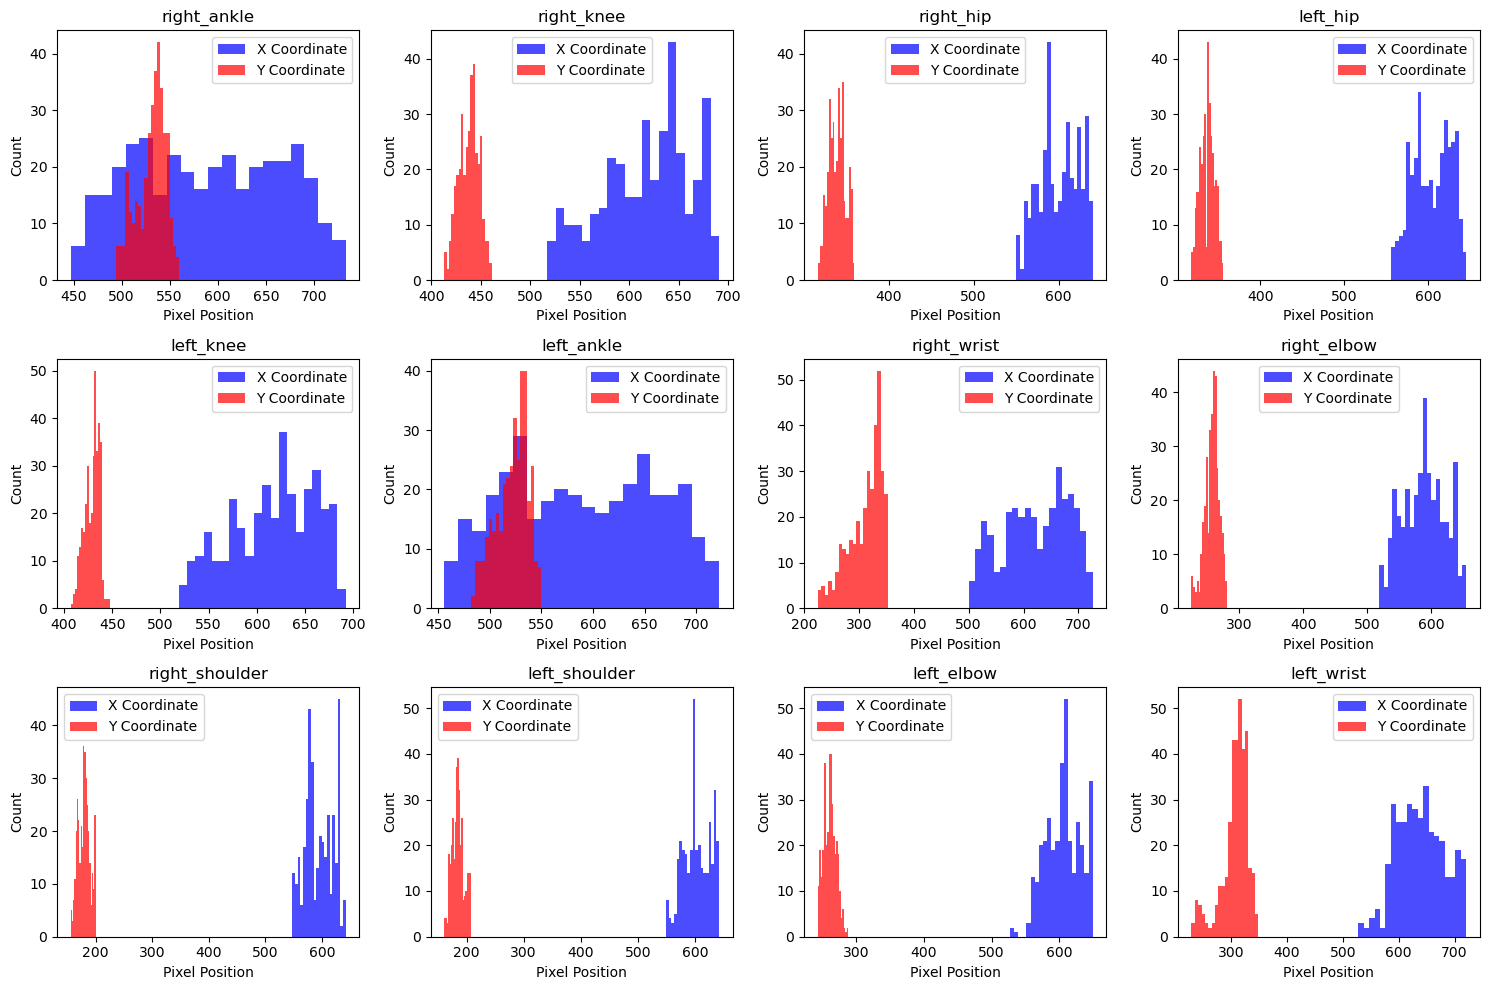

In [ ]:
root = tk.Tk()
root.title("Pose Detection App")
root.configure(bg="#f0f0f0")
root.minsize(400, 300)
heading_label = tk.Label(root, text="Gait Detection", font=("Arial", 18, "bold"))

# Place the label in the window
heading_label.pack(pady=20)
# Configure font
font_style = ("Arial", 12)
upload_button = tk.Button(root, text="Upload Video", command=upload_file)
upload_button.pack()

video_label = tk.Label(root)
video_label.pack()

result_label = tk.Label(root)
result_label.pack()


root.mainloop()